<a href="https://colab.research.google.com/github/Cham0703/DU_AN_SPAM/blob/main/main_email_detechtion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code 1

Đã đoán encoding: Windows-1252
Số lượng ham/spam:
label
ham     4825
spam     747
Name: count, dtype: int64


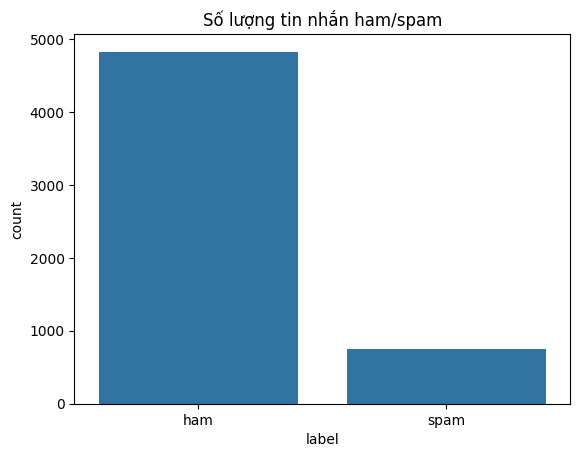

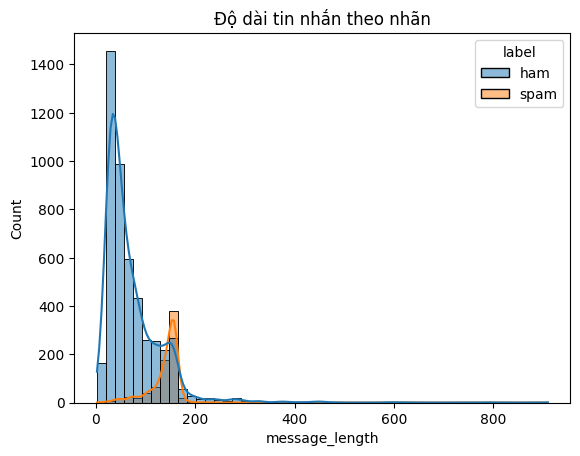

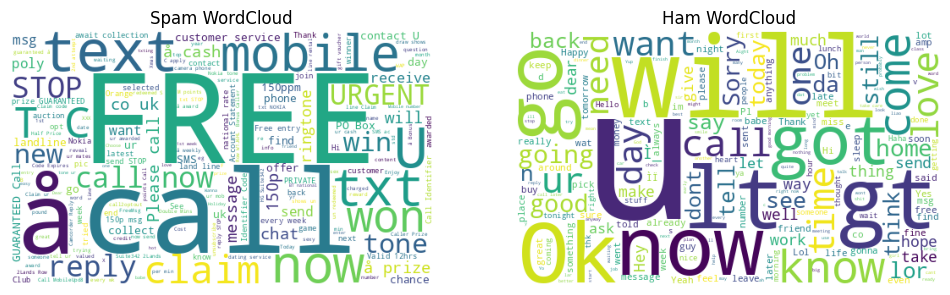

  label                                    cleaned_message
0   ham  go jurong point crazy available bugis n great ...
1   ham                            ok lar joking wif u oni
2  spam  free entry wkly comp win fa cup final tkts st ...
3   ham                u dun say early hor u c already say
4   ham        nah dont think goes usf lives around though


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import chardet
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
# 🧾 BƯỚC 1: Đọc file từ ổ đĩa
duong_dan = "spam.csv"
# Tự động phát hiện encoding của file để tránh lỗi khi đọc
with open(duong_dan, "rb") as f:
    result = chardet.detect(f.read(10000))  # Đọc thử 10.000 byte
    encoding = result['encoding']
    print(f"Đã đoán encoding: {encoding}")
# Đọc dữ liệu và chuẩn hóa cột
df = pd.read_csv(duong_dan, encoding=encoding)
df = df[['v1', 'v2']]                    # Lấy 2 cột cần thiết
df.columns = ['label', 'message']       # Đặt tên cột rõ ràng
# 📊 BƯỚC 2: Khám phá dữ liệu (EDA)
# Thống kê số lượng ham/spam
print("Số lượng ham/spam:")
print(df['label'].value_counts())
# Vẽ biểu đồ cột số lượng
sns.countplot(data=df, x='label')
plt.title("Số lượng tin nhắn ham/spam")
plt.show()
# Tính độ dài tin nhắn
df['message_length'] = df['message'].apply(len)
# Vẽ biểu đồ phân bố độ dài tin nhắn
sns.histplot(data=df, x='message_length', hue='label', bins=50, kde=True)
plt.title("Độ dài tin nhắn theo nhãn")
plt.show()
# ☁️ BƯỚC 3: Tạo WordCloud
spam_text = ' '.join(df[df['label'] == 'spam']['message'])
ham_text = ' '.join(df[df['label'] == 'ham']['message'])
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.imshow(WordCloud(width=500, height=300, background_color='white').generate(spam_text))
plt.axis("off")
plt.title("Spam WordCloud")
plt.subplot(1, 2, 2)
plt.imshow(WordCloud(width=500, height=300, background_color='white').generate(ham_text))
plt.axis("off")
plt.title("Ham WordCloud")
plt.show()
# 🧹 BƯỚC 4: Làm sạch tin nhắn
# Đường dẫn đến file spam.csv của bạn
duong_dan = "spam.csv"
# Phát hiện encoding để tránh lỗi Unicode
with open(duong_dan, "rb") as f:
    encoding = chardet.detect(f.read())['encoding']
# Đọc dữ liệu và đổi tên cột
df = pd.read_csv(duong_dan, encoding=encoding)[['v1', 'v2']]
df.columns = ['label', 'message']
# Tải stopwords nếu chưa có
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
# Hàm làm sạch văn bản
def clean_message(msg):
    msg = msg.lower()                              # Chuyển sang chữ thường
    msg = re.sub(r'\d+', '', msg)                 # Xoá chữ số
    msg = re.sub(r'[^\w\s]', '', msg)             # Xoá dấu câu
    words = msg.split()                           # Tách từ
    words = [w for w in words if w not in stop_words]  # Bỏ stop words
    return ' '.join(words)
# Tạo cột mới chứa tin nhắn đã làm sạch
df['cleaned_message'] = df['message'].apply(clean_message)
# Chỉ giữ lại hai cột yêu cầu: nhãn và tin nhắn đã làm sạch
df_output = df[['label', 'cleaned_message']]
# Hiển thị 5 dòng đầu để kiểm tra
print(df_output.head())

Code 2

In [46]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

duong_dan = "spam.csv"

# BƯỚC 1: Chuyển đổi nhãn sang dạng số
# Chuyển 'ham' thành 0, 'spam' thành 1
df['label_num'] = df['label'].map({'ham': 0, 'spam': 1})

# In ra để kiểm tra
print("Số lượng mẫu theo nhãn số:")
print(df['label_num'].value_counts())

# BƯỚC 2: Chuyển đổi tin nhắn thành đặc trưng số
# Sử dụng CountVectorizer (Mô hình Bag of Words)
count_vectorizer = CountVectorizer(max_features=5000)  # Giới hạn 5000 từ phổ biến nhất
X_count = count_vectorizer.fit_transform(df['cleaned_message'])

# Sử dụng TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(df['cleaned_message'])

# In ra kích thước của dữ liệu sau khi chuyển đổi
print(f"Kích thước dữ liệu CountVectorizer: {X_count.shape}")
print(f"Kích thước dữ liệu TF-IDF: {X_tfidf.shape}")

# BƯỚC 3: Chia dữ liệu thành tập huấn luyện và tập kiểm tra
# Sử dụng cả hai loại đặc trưng để so sánh
# Sử dụng CountVectorizer
X_count_train, X_count_test, y_count_train, y_count_test = train_test_split(
    X_count, df['label_num'], test_size=0.2, random_state=42, stratify=df['label_num']
)

# Sử dụng TF-IDF
X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test = train_test_split(
    X_tfidf, df['label_num'], test_size=0.2, random_state=42, stratify=df['label_num']
)

# BƯỚC 4: Lưu từ vựng để sử dụng sau này
count_vocab = count_vectorizer.get_feature_names_out()
tfidf_vocab = tfidf_vectorizer.get_feature_names_out()

# In ra thông tin về tập huấn luyện và kiểm tra
print("\nThông tin về bộ dữ liệu đã chia:")
print(f"Số lượng mẫu huấn luyện: {X_count_train.shape[0]}")
print(f"Số lượng mẫu kiểm tra: {X_count_test.shape[0]}")
print(f"Tỷ lệ spam trong tập huấn luyện: {y_count_train.mean()*100:.2f}%")
print(f"Tỷ lệ spam trong tập kiểm tra: {y_count_test.mean()*100:.2f}%")


output_summary = {
    'CountVectorizer': {
        'X_train shape': X_count_train.shape,
        'X_test shape': X_count_test.shape,
        'y_train shape': y_count_train.shape,
        'y_test shape': y_count_test.shape,
        'vocabulary size': len(count_vocab)
    },
    'TfidfVectorizer': {
        'X_train shape': X_tfidf_train.shape,
        'X_test shape': X_tfidf_test.shape,
        'y_train shape': y_tfidf_train.shape,
        'y_test shape': y_tfidf_test.shape,
        'vocabulary size': len(tfidf_vocab)
    }
}

print("\nTổng kết:")
for method, details in output_summary.items():
    print(f"\n{method}:")
    for key, value in details.items():
        print(f"  - {key}: {value}")

Số lượng mẫu theo nhãn số:
label_num
0    4825
1     747
Name: count, dtype: int64
Kích thước dữ liệu CountVectorizer: (5572, 5000)
Kích thước dữ liệu TF-IDF: (5572, 5000)

Thông tin về bộ dữ liệu đã chia:
Số lượng mẫu huấn luyện: 4457
Số lượng mẫu kiểm tra: 1115
Tỷ lệ spam trong tập huấn luyện: 13.42%
Tỷ lệ spam trong tập kiểm tra: 13.36%

Tổng kết:

CountVectorizer:
  - X_train shape: (4457, 5000)
  - X_test shape: (1115, 5000)
  - y_train shape: (4457,)
  - y_test shape: (1115,)
  - vocabulary size: 5000

TfidfVectorizer:
  - X_train shape: (4457, 5000)
  - X_test shape: (1115, 5000)
  - y_train shape: (4457,)
  - y_test shape: (1115,)
  - vocabulary size: 5000


Coder 3

Import thư viện và định nghĩa mô hình

In [47]:
# Imports chung
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# Imports model
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

# Import cho cross-validation
from sklearn.model_selection import cross_val_score

# Import pickle để lưu mô hình
import pickle

# Định nghĩa danh sách mô hình
models = {
    'MultinomialNB': MultinomialNB(),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'SVM': SVC(kernel='linear', probability=True),
    'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier(n_estimators=100),
    'KNN': KNeighborsClassifier(),
    'AdaBoost': AdaBoostClassifier(n_estimators=50),
    'Bagging': BaggingClassifier(n_estimators=50),
    'ExtraTrees': ExtraTreesClassifier(n_estimators=100),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=100),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

Hàm đánh giá và dùng Cross- Validation đánh giá sự ổn đinh của mô *hình*

In [48]:
# Hàm đánh giá mô hình trên tập test
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return {'Model': name, 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1-score': f1}

# Hàm đánh giá cross-validation
def evaluate_model_cv(model, X, y, cv=5, scoring='f1'):
    scores = cross_val_score(model, X, y, cv=cv, scoring=scoring)
    return scores.mean(), scores.std()

Cross-validation

In [ ]:
# Đánh giá bằng Cross-validation (cho tất cả mô hình)
cv_results = []
y = df['label_num']  # Sử dụng df['label_num'] làm nhãn

for feat_name, X in {
    'Count': X_count,
    'TF-IDF': X_tfidf
}.items():
    for name, model in models.items():
        try:
            mean_score, std_score = evaluate_model_cv(model, X, y)
            cv_results.append({
                'Feature': feat_name,
                'Model': name,
                'Mean F1-score': mean_score,
                'Std F1-score': std_score
            })
        except Exception as e:
            print(f"Lỗi khi chạy cross-validation cho {name} trên {feat_name}: {str(e)}")

# Chuyển kết quả thành DataFrame
df_cv_results = pd.DataFrame(cv_results)
print("\nKết quả Cross-validation:")
display(df_cv_results)

Cross-validation

In [ ]:
# Đánh giá bằng Cross-validation
cv_results = []
for feat_name, (X, y) in {
    'Count': (X_count, y_count),
    'TF-IDF': (X_tfidf, y_tfidf)
}.items():
    print(f"\nĐánh giá cross-validation với đặc trưng: {feat_name}")
    for name, model in models.items():
        mean_score, std_score = evaluate_model_cv(model, X, y)
        print(f"Model: {name}, Mean F1-score: {mean_score:.4f}, Std: {std_score:.4f}")
        cv_results.append({
            'Feature': feat_name,
            'Model': name,
            'Mean F1-score': mean_score,
            'Std F1-score': std_score
        })

# Chuyển kết quả cross-validation thành DataFrame
df_cv_results = pd.DataFrame(cv_results)
print("\nKết quả Cross-validation:")
df_cv_results

Huấn luyện và đánh giá mô hình

In [ ]:
# Huấn luyện và đánh giá trên tập train/test
results = []
for feat_name, (X_train, X_test, y_train, y_test) in {
    'Count': (X_count_train, X_count_test, y_count_train, y_count_test),
    'TF-IDF': (X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test)
}.items():
    print(f"\nĐánh giá với đặc trưng trên tập test: {feat_name}")
    for name, model in models.items():
        model.fit(X_train, y_train)
        res = evaluate_model(name, model, X_test, y_test)
        res['Feature'] = feat_name
        results.append(res)

# Chuyển kết quả trên tập test thành DataFrame
df_results = pd.DataFrame(results)
print("\nKết quả trên tập test:")
df_results

Hiển thị top 5 mô hình

In [ ]:
# Hiển thị top 5 mô hình theo F1-score
for feat in ['Count', 'TF-IDF']:
    df_feat = df_results[df_results['Feature'] == feat]
    top5 = df_feat.sort_values('F1-score', ascending=False).head(5)
    print(f"\nTop 5 mô hình trên {feat} theo F1-score:")
    display(top5[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-score']])

    # Vẽ barplot F1-score
    plt.figure(figsize=(8, 4))
    sns.barplot(data=top5, x='F1-score', y='Model')
    plt.title(f"Top 5 mô hình ({feat}) theo F1-score")
    plt.xlabel("F1-score")
    plt.ylabel("Model")
    plt.tight_layout()
    plt.show()

Confusion Matrix cho 3 model tối ưu nhất

In [ ]:
# Vẽ ma trận nhầm lẫn cho 3 mô hình tốt nhất
top_3_rows = df_results.sort_values('F1-score', ascending=False).iloc[:3]
for index, row in top_3_rows.iterrows():
    feat = row['Feature']
    model_name = row['Model']
    print(f"\nModel: {model_name} trên {feat} (F1={row['F1-score']:.4f})")

    best_model = models[model_name]
    if feat == 'TF-IDF':
        X_tr, X_te, y_tr, y_te = X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test
    else:
        X_tr, X_te, y_tr, y_te = X_count_train, X_count_test, y_count_train, y_count_test

    best_model.fit(X_tr, y_tr)
    y_pred = best_model.predict(X_te)
    cm = confusion_matrix(y_te, y_pred)

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix: {model_name} ({feat})')
    plt.show()

Lưu lại Model

In [ ]:
with open('best_spam_model.pkl','wb') as f:
    pickle.dump({
        'model': best_model,
        'vectorizer': tfidf_vectorizer
    }, f)
print("Đã lưu model và vectorizer vào best_spam_model.pkl")
